# Distance based Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

### We load the required datasets

In [2]:
np.random.seed(2025)
X1, y1 = get_classification_dataset()  # Linearly separable dataset
X2, y2 = get_classification_dataset(var=1.0)  # Linearly non-separable dataset
X3, y3 = get_regression_dataset()  # Regression dataset

## Let's visualize the datasets

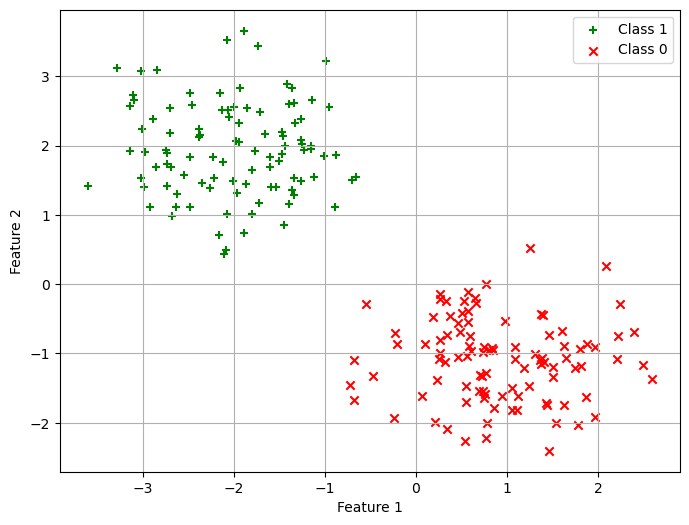

In [3]:
plot_classification_datapoints(X1, y1)

## Split the dataset into training and test sets

In [4]:
X_train1, y_train1, X_test1, y_test1 = train_test_split(X1, y1)

## Let's explore some strategies

## Strategy 1 - We memorize the dataset

Strategy must be able to handle the following scenarios:
- *Case 1* - when the new datapoint belongs to the dataset
- *Case 2* - when the new datapoint is close to but not exactly same as datapoints in the dataset
- *Case 3* - when the new datapoint is sufficiently far away from multiple datapoints in the dataset

In [5]:
y_preds = []
for x in X_test1:
    distances = np.linalg.norm(X_train1 - x, axis=1)
    closest = np.argmin(distances)
    y_preds.append(y_train1[closest])
y_preds = np.array(y_preds)
acc = np.mean(y_preds == y_test1)
print(acc)

1.0


What about a different dataset?
- *Case 4* - what if the dataset itself is noisy?

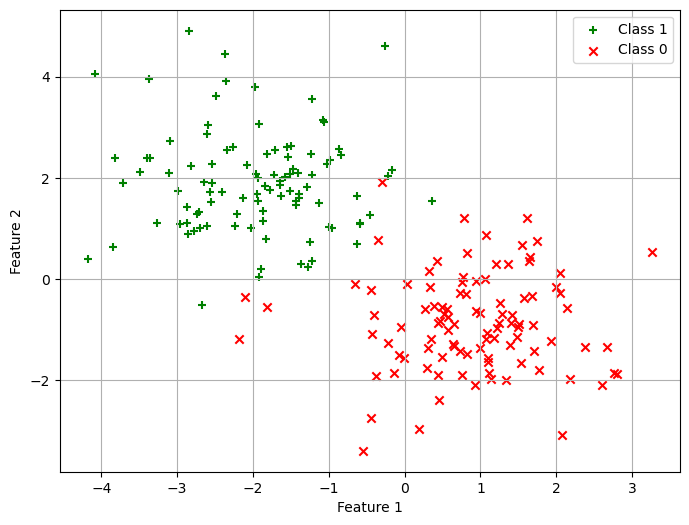

0.95


In [6]:
plot_classification_datapoints(X2, y2)
X_train, y_train, X_test, y_test = train_test_split(X2, y2)
y_preds = []
for x in X_test:
    distances = np.linalg.norm(X_train - x, axis=1)
    closest = np.argmin(distances)
    y_preds.append(y_train1[closest])
y_preds = np.array(y_preds)
acc = np.mean(y_preds == y_test)
print(acc)

### k-Nearest Neighbor algorithm

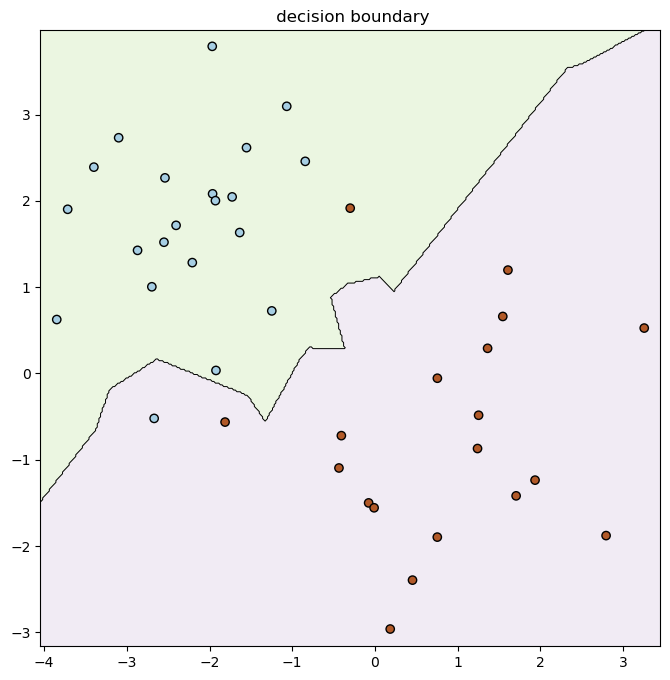

In [7]:
class kNNModel:
    def __init__(self, k=5):
        self.X = None
        self.y = None
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        y_preds = []
        for x in X:
            distances = np.linalg.norm(self.X - x, axis=1)
            closest_idxs = np.argsort(distances)[:self.k]
            y_preds.append(np.mean(self.y[closest_idxs]))
            # y_preds.append(np.argmax(np.bincount(self.y[closest_idxs])))
        return np.array(y_preds)


model = kNNModel(k=1)
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

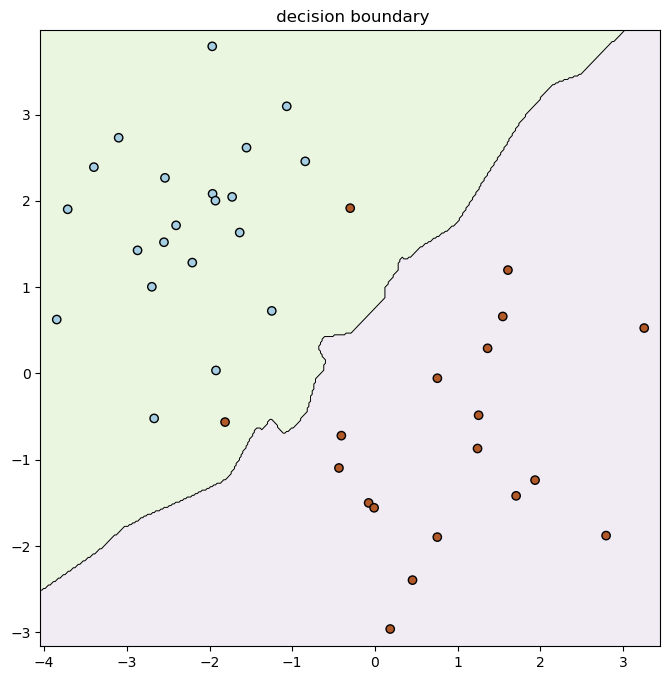

In [8]:
model = kNNModel(k=5)
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

### Other approaches to kNN 

- *Case 5* - What about a different notion of "closeness"

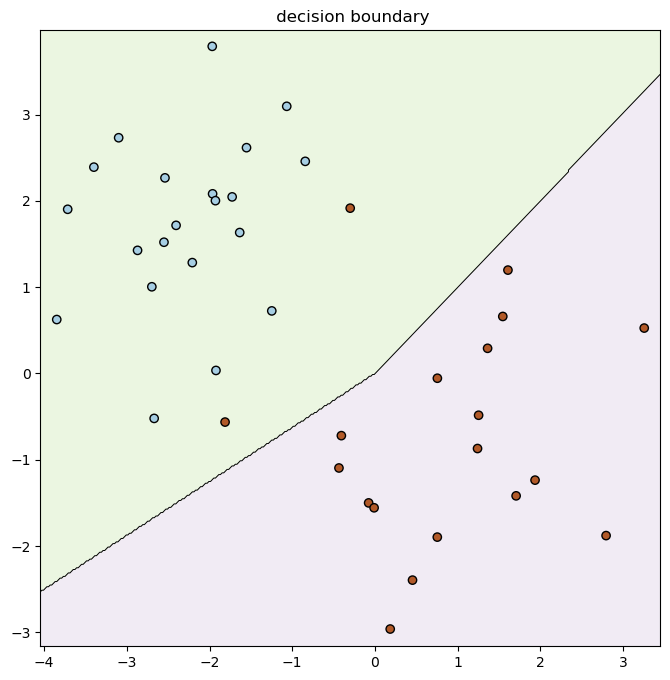

In [9]:
class kNNModel2:
    def __init__(self, k=5):
        self.X = None
        self.y = None
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        assert self.X is not None, "You must fit the model first"
        y_preds = []
        for x in X:
            # distances = np.linalg.norm(self.X - x, axis=1)
            similarities = np.sum(self.X * x, axis=1)
            closest_idxs = np.argsort(similarities)[-self.k:]
            y_preds.append(np.mean(self.y[closest_idxs]))
            # y_preds.append(np.argmax(np.bincount(self.y[closest_idxs])))
        return np.array(y_preds)


X_train, y_train, X_test, y_test = train_test_split(X2, y2)
model = kNNModel2(k=5)
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

- *Case 6* - Why should we give equal weightage to each datapoint?

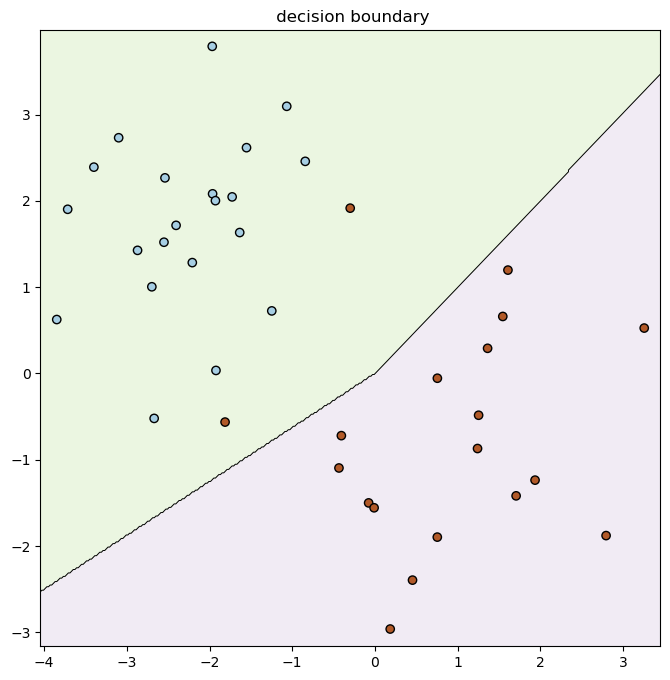

In [10]:
class kNNModel3:
    def __init__(self, k=5):
        self.X = None
        self.y = None
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        assert self.X is not None, "You must fit the model first"
        y_preds = []
        for x in X:
            similarities = np.sum(self.X * x, axis=1)
            closest_idxs = np.argsort(similarities)[-self.k:]
            values = similarities[closest_idxs]
            normalized_values = values / np.sum(values)
            y_preds.append(np.sum(normalized_values * self.y[closest_idxs]))
        return np.array(y_preds)


X_train, y_train, X_test, y_test = train_test_split(X2, y2)
model = kNNModel3(k=5)
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

- *Case 7* - What if we need to perform regression instead of classification?

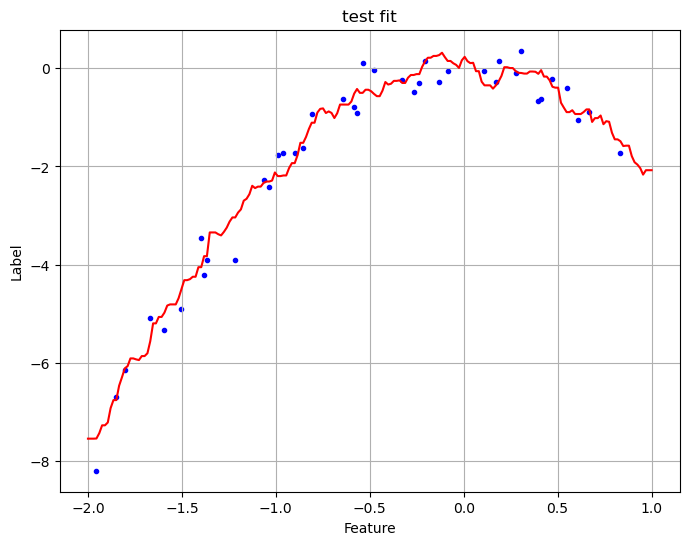

In [11]:
X_train, y_train, X_test, y_test = train_test_split(X3, y3)

model = kNNModel(k=5)
model.fit(X_train, y_train)
# plot_fit(model, X_train, y_train, partition='train')
plot_fit(model, X_test, y_test, partition='test')

### Quiz

What are some drawbacks of the kNN algorithm?

## Strategy 2 - We learn something useful from the dataset and then discard the dataset
What are the advantages of such a strategy?

### Distance based strategy?

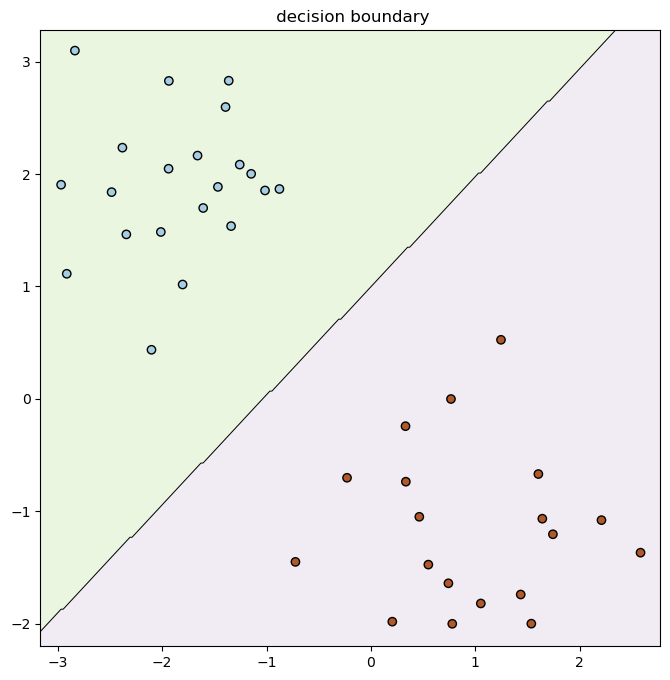

In [12]:
class DAModel:
    def __init__(self):
        self.means = None
    
    def fit(self, X, y):
        self.means = np.empty((len(np.unique(y)), X.shape[1]), dtype=X.dtype)
        for i, label in enumerate(np.unique(y)):
            self.means[i] = np.mean(X[y == label], axis=0)
    
    def predict(self, X):
        assert self.means is not None, "You must fit the model first"
        y_preds = []
        for x in X:
            distances = np.linalg.norm(self.means - x, axis=1)
            y_preds.append(np.argmin(distances))
        return np.array(y_preds)

X_train, y_train, X_test, y_test = train_test_split(X1, y1)

model = DAModel()
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

### Quadratic Discriminant Analysis

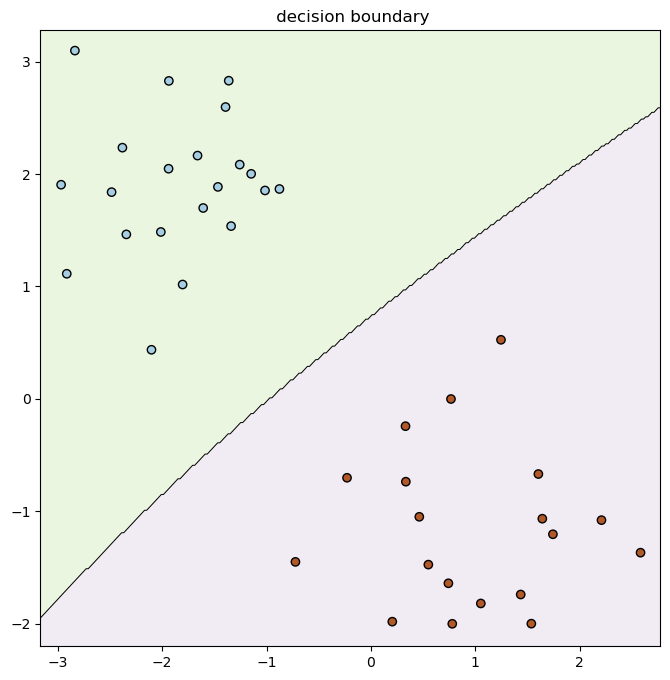

In [13]:
class QDAModel:
    def __init__(self):
        self.means = None
        self.covs = None
        self.priors = None
    
    def fit(self, X, y):
        self.means = np.empty((len(np.unique(y)), X.shape[1]), dtype=X.dtype)
        self.covs = np.empty((len(np.unique(y)), X.shape[1], X.shape[1]), dtype=X.dtype)
        self.priors = np.empty(len(np.unique(y)), dtype=X.dtype)
        for i, label in enumerate(np.unique(y)):
            self.means[i] = np.mean(X[y == label], axis=0)
            self.covs[i] = np.cov(X[y == label].T)
            self.priors[i] = np.mean(y == label)
        self.log_pi_by_sigma_1 = np.log(self.priors[1]) - 0.5 * np.log(np.linalg.det(self.covs[1]))
        self.log_pi_by_sigma_0 = np.log(self.priors[0]) - 0.5 * np.log(np.linalg.det(self.covs[0]))
        self.log_sigma_inv_1 = np.linalg.pinv(self.covs[1])
        self.log_sigma_inv_0 = np.linalg.pinv(self.covs[0])
    
    def predict(self, X):
        assert self.means is not None, "You must fit the model first"
        y_preds = []
        for x in X:
            numerator = self.log_pi_by_sigma_1 - 0.5 * (x-self.means[1]).T @ self.log_sigma_inv_1 @ (x-self.means[1])
            denominator = self.log_pi_by_sigma_0 - 0.5 * (x-self.means[0]).T @ self.log_sigma_inv_0 @ (x-self.means[0])
            y_preds.append(1 if numerator > denominator else 0)
        return np.array(y_preds)

model = QDAModel()
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

### Linear Discriminant Analysis

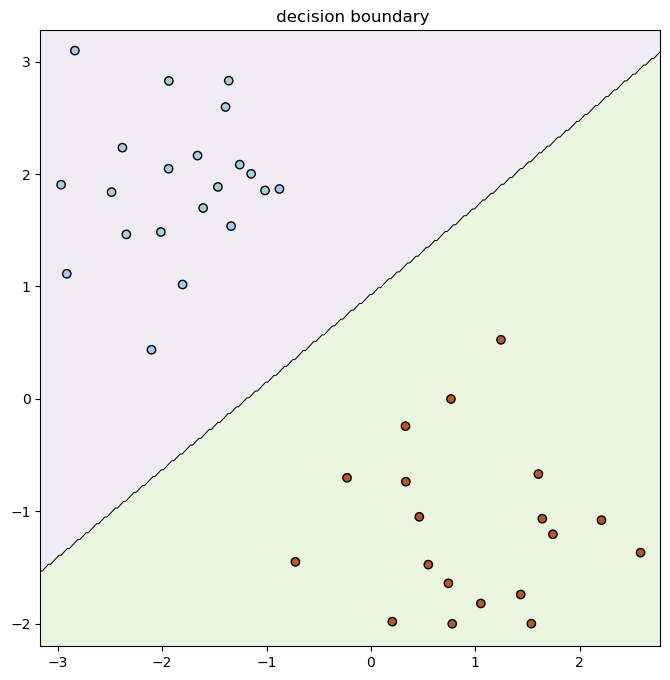

In [14]:
class LDAModel:
    def __init__(self):
        self.means = None
        self.cov = None
        self.priors = None
    
    def fit(self, X, y):
        self.means = np.empty((len(np.unique(y)), X.shape[1]), dtype=X.dtype)
        self.cov = np.cov(X.T)
        self.priors = np.empty(len(np.unique(y)), dtype=X.dtype)
        for i, label in enumerate(np.unique(y)):
            self.means[i] = np.mean(X[y == label], axis=0)
            self.priors[i] = np.mean(y == label)
        self.w = np.linalg.pinv(self.cov) @ (self.means[0] - self.means[1])
        self.C = np.log(self.priors[1] / self.priors[0])
        self.C += 0.5 * self.means[0].T @ np.linalg.pinv(self.cov) @ self.means[0]
        self.C -= 0.5 * self.means[1].T @ np.linalg.pinv(self.cov) @ self.means[1]
    
    def predict(self, X):
        assert self.means is not None, "You must fit the model first"
        y_preds = []
        for x in X:
            y_pred = 1 if self.w.T @ x > self.C else 0
            y_preds.append(y_pred)
        return np.array(y_preds)


model = LDAModel()
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)

### Linear Regression (to be continued)